# Projet de modélisation non supervisée des fonctionnalités de prédiction des tags 

## Imports

In [82]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
import nltk.data
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import string
from langdetect import detect
import re
import spacy
from spacy.symbols import ORTH, NORM
from langdetect import detect_langs
import langid
from bs4 import BeautifulSoup

import gensim
from gensim import corpora, models
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary        


import tqdm

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from collections import Counter

from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

import pickle

from sklearn import preprocessing

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)


## Import dataset

In [83]:
data = pd.read_csv('./dataset/preprocessed_dataset.csv',sep=",")

In [84]:
data.head()

,body,tags
0,write daemon run emb platform need chang default rout devic accord interfac connect give time programat know use system rout del default rout add default gateway blah etc direct way updat solv particular problem discov patch pppd allow replacedefaultrout option patch also includ code programmat modifi rout tabl includ gentoo bug report,"c,linux,networking"
1,use gdi+ c++ two problem find canvasimg black chang color white mean want white canva draw thing canva clear canva mani thank,"canvas,gdi+"
2,write program need determin bit set know rotat word leav right shift access individu bite state use bitwis oper like xor,"assembly,bit-manipulation,mips"
3,consol applic server accept sever connect client possibl listen event close applic want event tell connect client gentl disconnect applic realli close solut thank,"java,events,listener"
4,attempt provid script solut read content file client machin browser solut work firefox internet explor pretti tri thing moment call write content filecont text area way browser concern safari chrome moment open suggest browser edit respons question want basic want hash file content togeth one time password client side send inform back verif,"javascript,html,file-io,sandbox"


## Modélisation non supervisée

Pour effectuer une modélisation non supervisée nous choisissons d'implémenter un modèle entrainé sur l'algorithme Latent Dirichlet Allocation (LDA par la suite).

L'algorithme a pour objectif d'établir une prédiction des topics relatifs à un ensemble de données textuelles. 

Il s'appuie sur 2 composants essentiels : 

    - Un dictionnaire, qui est l'ensemble des termes du langage
    - Le corpus, qui est l'ensemble des règles caractérisant les termes du langage (description, fréquence, etc, ...)


### Mise en place d'une baseline

On met en place une baseline à partir d'un LDA s'appuyant sur un bag of words simple.

#### Bag of Words

In [85]:
def tokenize(text):
    result = []
    #print(type(text))
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(token)
    return result

processed_body = data['body'].map(tokenize)
processed_body[:10]

dictionary = gensim.corpora.Dictionary(processed_body)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 accord
1 add
2 allow
3 blah
4 bug
5 chang
6 code
7 connect
8 daemon
9 default
10 del


#### Dictionnaire

On crée pour chaque post un dictionnaire qui met en perspective combien de mots il comprend et combien de fois ce mot apparait.

In [86]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_body]

In [87]:
bow_corpus[1]

[(5, 1),
 (27, 1),
 (37, 1),
 (40, 1),
 (41, 3),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 2)]

#### Preview du Bag of Words

In [88]:
bow_show = bow_corpus[10]
for i in range(len(bow_show)):
    print("Word {} (\"{}\") appears {} time.".format(bow_show[i][0], 
                                               dictionary[bow_show[i][0]], 
                                                bow_show[i][1]))

Word 2 ("allow") appears 1 time.
Word 27 ("problem") appears 2 time.
Word 37 ("use") appears 4 time.
Word 38 ("way") appears 4 time.
Word 48 ("mean") appears 1 time.
Word 49 ("thank") appears 1 time.
Word 50 ("thing") appears 1 time.
Word 51 ("want") appears 2 time.
Word 53 ("access") appears 2 time.
Word 60 ("like") appears 3 time.
Word 80 ("realli") appears 1 time.
Word 83 ("solut") appears 1 time.
Word 104 ("pretti") appears 1 time.
Word 106 ("question") appears 1 time.
Word 117 ("work") appears 2 time.
Word 120 ("deriv") appears 5 time.
Word 128 ("implement") appears 3 time.
Word 129 ("list") appears 1 time.
Word 132 ("object") appears 1 time.
Word 135 ("type") appears 11 time.
Word 137 ("actual") appears 1 time.
Word 157 ("class") appears 2 time.
Word 163 ("day") appears 1 time.
Word 186 ("obvious") appears 1 time.
Word 201 ("turn") appears 1 time.
Word 211 ("come") appears 2 time.
Word 220 ("fair") appears 1 time.
Word 225 ("input") appears 1 time.
Word 261 ("abil") appears 1 tim

#### Exécution d'un LDA sur la base du Bag of Words

On définit un nombre de topic à 50 en rapport avec la volumétrie du dataset d'analyse.

In [8]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=50, 
                                       id2word=dictionary, passes=10, workers=7,
                                       random_state=100,chunksize=100,per_word_topics=True)

In [9]:
show = []
for idx, topic in lda_model.print_topics(-1):
    show.append('Topic: {} \nWords: {}'.format(idx, topic))
show[0:5]

['Topic: 0 \nWords: 0.057*"tag" + 0.041*"click" + 0.038*"user" + 0.030*"map" + 0.028*"count" + 0.025*"menu" + 0.020*"instanc" + 0.020*"like" + 0.017*"submit" + 0.016*"abl"',
 'Topic: 1 \nWords: 0.107*"tabl" + 0.050*"sql" + 0.040*"column" + 0.039*"queri" + 0.031*"record" + 0.028*"row" + 0.023*"insert" + 0.022*"use" + 0.017*"statement" + 0.017*"linq"',
 'Topic: 2 \nWords: 0.329*"object" + 0.038*"copi" + 0.020*"new" + 0.018*"refer" + 0.014*"calcul" + 0.014*"creat" + 0.011*"persist" + 0.011*"time" + 0.010*"live" + 0.009*"load"',
 'Topic: 3 \nWords: 0.087*"valu" + 0.068*"form" + 0.034*"display" + 0.025*"control" + 0.024*"edit" + 0.024*"select" + 0.022*"set" + 0.020*"row" + 0.017*"textbox" + 0.016*"like"',
 'Topic: 4 \nWords: 0.108*"event" + 0.023*"handler" + 0.022*"branch" + 0.019*"use" + 0.016*"work" + 0.016*"merg" + 0.016*"checkbox" + 0.015*"check" + 0.015*"attribut" + 0.013*"handl"']

### Mesure des performances

Pour le LDA on mesure les indicateurs de perplexité et de cohérence du modèle 

In [9]:
"""
-----------------------------------------------------------------
Desc:   fonction de calcul de indicateur de performance
        du model
Input:  model
        corpus
        lemmas
        dictionnaire
Output: output console   

Traitements appliqués : 
- n/a 
-----------------------------------------------------------------
"""
def computeLDAPerfIndicators(model, corpus, lemmas, dictionary):
    #Perplexité
    print('\nPerplexity Score: ' + str(model.log_perplexity(corpus)))
    
    # Cohérence
    coherence_model_lda = CoherenceModel(model=model, texts=lemmas, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

In [ ]:
computeLDAPerfIndicators(lda_model, bow_corpus, processed_body, dictionary)


Perplexity Score: -10.43308359269121


### Amélioration: Feature engineering avec TF-IDF

Création d'un modèle TF-IDF sur bow_corpus

In [16]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.11565658447272077),
 (1, 0.05754279720573613),
 (2, 0.08449939921946943),
 (3, 0.17417548187125143),
 (4, 0.11731433042675461),
 (5, 0.060453178982257834),
 (6, 0.03860108639529847),
 (7, 0.08828895937818372),
 (8, 0.1798532627224299),
 (9, 0.2745013001030148),
 (10, 0.1844212620708418),
 (11, 0.12694560310863812),
 (12, 0.08792191448817356),
 (13, 0.1409138405283942),
 (14, 0.11953868087452152),
 (15, 0.19312919901941702),
 (16, 0.23103663331574822),
 (17, 0.16722631889183848),
 (18, 0.09772712316120548),
 (19, 0.045150802151398724),
 (20, 0.10443565681292098),
 (21, 0.04166015436551212),
 (22, 0.08380066486911258),
 (23, 0.097519179697227),
 (24, 0.31044352944617165),
 (25, 0.12221449203997013),
 (26, 0.24999035046391382),
 (27, 0.050960363661180175),
 (28, 0.15608991490035537),
 (29, 0.13051027319891328),
 (30, 0.10225719679793979),
 (31, 0.5485447910087591),
 (32, 0.05407512882911201),
 (33, 0.10140829919749607),
 (34, 0.06720342802533767),
 (35, 0.05709041924265162),
 (36, 

#### Exécution d'un LDA utilisant notre TF-IDF

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=50, id2word=dictionary, passes=10, workers=7,
                                       random_state=100,chunksize=100,per_word_topics=True)

In [ ]:
show = []
for idx, topic in lda_model_tfidf.print_topics(-1):
    show.append('Topic: {} Word: {}'.format(idx, topic))
show[0:5]

#### Mesure des perfs

In [ ]:
computeLDAPerfIndicators(lda_model_tfidf, corpus_tfidf, processed_body, dictionary)

Le score de cohérence est plus élevé, ce qui ne signifie pas que l'algorithme fonctionne mieux. Il nous faut régler les hyperparamètres pour conduire au mieux l'algorithme probabiliste.

#### Réglage des hyperparamètres

On joue sur les hyperparamètres suivants:

    - nombre de topics
    - alpha: sensibilité à la densité de topics par document
    - beta: sensibilité à la densité de mots par topic 

In [ ]:
def compute_coherence_values(corpus, dictionary, lemmas, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                            workers=7,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmas, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 50
max_topics = 150
step_size = 10
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus_tfidf)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus_tfidf, int(num_of_docs*0.25)), 
               # gensim.utils.ClippedCorpus(corpus_tfidf, int(num_of_docs*0.5)), 
               gensim.utils.ClippedCorpus(corpus_tfidf, int(num_of_docs*0.75)), 
               corpus_tfidf]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# loop to fix hyperparam best value 1 each at a time
if 1 == 1:
    total = len(corpus_sets) * len(topics_range) * len(alpha) * len(beta)
    pbar = tqdm.tqdm(total=total)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=dictionary, 
                                                  lemmas=processed_body,
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

#### Exploitation des résultats

Pour chaque validation set on recherche le nombre optimal de clusters qui est celui pour lequel le score de cohérence atteint son premier maximum. Associé à ce score nous saurons également déterminer 'alpha', 'beta'.

In [10]:
hyperparams_results = pd.read_csv('lda_tuning_results.csv',sep=",")

In [11]:
hyperparams_results.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,50,0.01,0.01,0.457478
1,75% Corpus,50,0.01,0.31,0.389925
2,75% Corpus,50,0.01,0.61,0.391896
3,75% Corpus,50,0.01,0.9099999999999999,0.386902
4,75% Corpus,50,0.01,symmetric,0.442185


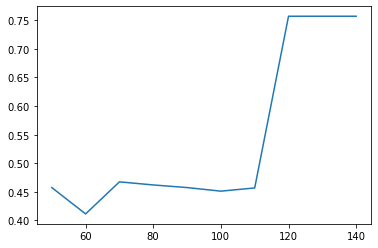

In [12]:
results_75_pc = hyperparams_results[hyperparams_results['Validation_Set' ] == '75% Corpus']
xtract = results_75_pc.query('Alpha == "0.01" and Beta == "0.01"')
plt.plot(xtract['Topics'],xtract['Coherence'])

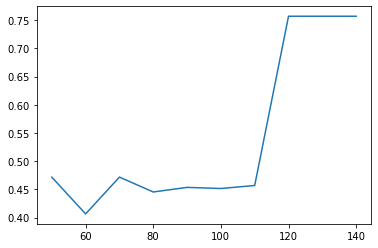

In [13]:
results_100_pc = hyperparams_results[hyperparams_results['Validation_Set' ] == '100% Corpus']
xtract = results_100_pc.query('Alpha == "0.01" and Beta == "0.01"')
plt.plot(xtract['Topics'],xtract['Coherence'])

On retient donc les hyperparams du nombre de topics le plus haut avant qu'il ne baisse, c'est à dire 50.

Pour déterminer les valeurs optimales de alpha et beta, on considère le score de cohérence le plus haut qui permettra d'avoir la meilleure distribution pour ce nombre de topics.

In [52]:
xtract = results_100_pc.query('Topics == "50"')
xtract = results_100_pc[results_100_pc['Topics' ] == 50]
xtract[xtract.Coherence == xtract.Coherence.max()]

,Validation_Set,Topics,Alpha,Beta,Coherence
308,100% Corpus,50,0.31,0.9099999999999999,0.672459


In [27]:
lda_model_tfidf_optimized = gensim.models.LdaMulticore(corpus_tfidf, num_topics=50, id2word=dictionary, passes=10, workers=7,
                                                       random_state=100, chunksize=100, per_word_topics=True,
                                                       alpha=0.01, eta=0.01)

In [28]:
show = []
for idx, topic in lda_model_tfidf_optimized.print_topics(-1):
    show.append('Topic: {} Word: {}'.format(idx, topic))
show[0:10]

['Topic: 0 Word: 0.023*"coordin" + 0.015*"overlay" + 0.006*"birthday" + 0.003*"pin" + 0.000*"map" + 0.000*"wikimapia" + 0.000*"locat" + 0.000*"wherebi" + 0.000*"cafe" + 0.000*"pint"',
 'Topic: 1 Word: 0.024*"servic" + 0.021*"thread" + 0.017*"pass" + 0.016*"java" + 0.014*"project" + 0.013*"paramet" + 0.013*"proxi" + 0.012*"interfac" + 0.012*"domain" + 0.012*"web"',
 'Topic: 2 Word: 0.047*"repeat" + 0.044*"appl" + 0.042*"layout" + 0.034*"worker" + 0.027*"cocoa" + 0.021*"flow" + 0.016*"metric" + 0.016*"sproc" + 0.011*"secondari" + 0.008*"wast"',
 'Topic: 3 Word: 0.073*"webservic" + 0.046*"convert" + 0.029*"persist" + 0.029*"interrupt" + 0.022*"json" + 0.020*"traffic" + 0.016*"slide" + 0.013*"prototyp" + 0.013*"array" + 0.011*"eval"',
 'Topic: 4 Word: 0.033*"cell" + 0.031*"equal" + 0.030*"layer" + 0.029*"vim" + 0.027*"combobox" + 0.026*"partial" + 0.025*"phase" + 0.025*"pop" + 0.017*"generic" + 0.016*"convent"',
 'Topic: 5 Word: 0.058*"mx" + 0.051*"templat" + 0.051*"django" + 0.025*"gmail"

In [29]:
computeLDAPerfIndicators(lda_model_tfidf_optimized, corpus_tfidf, processed_body, dictionary)


Perplexity Score: -31.746581973356257

Coherence Score:  0.46747547326448424


On a donc amélioré le modèle par rapport à la baseline : 

    Coherence(baseline) = 0.35
    Coherence(opti) = 0.28

### Analyse des résultats obtenus

En suivant une démarche non supervisée nous devons comprendre l'information portée par le modèle résultant afin de l'exploiter.

#### Quel est le topic prédominant pour chaque post ?

Chaque post peut être représenté par 1 à n topics, on cherche à ressortir le topic prédominant 

In [30]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [31]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf_optimized, corpus=corpus_tfidf, texts=processed_body)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.2828,"file, use, like, class, code, need, way, object, applic, work","[write, daemon, run, emb, platform, need, chang, default, rout, devic, accord, interfac, connect, time, programat, know, use, rout, del, default, rout, add, default, gateway, blah, direct, way, updat, solv, particular, problem, discov, patch, pppd, allow, option, patch, includ, code, programmat, modifi, rout, tabl, includ, gentoo, bug, report]"
1,1,19.0,0.3258,"file, use, like, class, code, need, way, object, applic, work","[use, gdi, problem, canvasimg, black, chang, color, white, mean, want, white, canva, draw, thing, canva, clear, canva, mani, thank]"
2,2,19.0,0.3382,"file, use, like, class, code, need, way, object, applic, work","[write, program, need, determin, bit, set, know, rotat, word, leav, right, shift, access, individu, bite, state, use, bitwis, oper, like, xor]"
3,3,19.0,0.5471,"file, use, like, class, code, need, way, object, applic, work","[consol, applic, server, accept, sever, connect, client, possibl, listen, event, close, applic, want, event, tell, connect, client, gentl, disconnect, applic, realli, close, solut, thank]"
4,4,19.0,0.4707,"file, use, like, class, code, need, way, object, applic, work","[attempt, provid, script, solut, read, content, file, client, machin, browser, solut, work, firefox, internet, explor, pretti, tri, thing, moment, write, content, filecont, text, area, way, browser, concern, safari, chrome, moment, open, suggest, browser, edit, respons, question, want, basic, want, hash, file, content, togeth, time, password, client, send, inform, verif]"
5,5,19.0,0.4573,"file, use, like, class, code, need, way, object, applic, work","[want, determin, generic, object, type, method, type, paramet, collect, type, typic, send, generic, list, collect, type, use, helper, function, best, test, implement, ienumer, code, look, like, updat, gmt, possibl, extend, solut, howev, work, list, ienumer, list, deriv]"
6,6,19.0,0.4859,"file, use, like, class, code, need, way, object, applic, work","[studi, test, wonder, equival, free, ptr, understand, work, free, function, actual, tell, memori, ptr, avail, use, sorri, kind, noob, question, help, appreci]"
7,7,19.0,0.5119,"file, use, like, class, code, need, way, object, applic, work","[littl, backround, yr, old, high, school, degre, lot, free, time, colleg, work, complet, new, web, program, coupl, day, class, photoshop, illustr, dreamweav, firework, indesign, day, class, mean, pro, familiar, adob, program, teacher, freelanc, web, design, tell, adob, program, learn, html, xhtml, css, flash, java, good, shape, regard, job, tell, good, design, program, realli, good, job, wonder, anyon, advic, inform, basic, noob, start, scratch, realli, want, profess, lynda, com, tri, program, stuff, tri, turn, skill, job, best, case, scenario, eventu, freelanc, support, obvious, far, away, advic, great, appreci]"
8,8,19.0,0.4569,"file, use, like, class, code, need, way, object, applic, work","[applic, user, input, text, form, data, save, mysql, databas, collat, output, xml, encod, utf, problem, peopl, tend, cut, past, inform, sourc, instanc, microsoft, word, document, pdfs, instanc, input, text, charact, incorrect, output, encod, thing, like, smart, quot, come, document, caus, problem, obvious, transform, otherwis, work, xml, charact, illeg, sanitis, input, previous, use, fair, brute, forc, method, thing, like, moron, script, consist, long, list, search, replac, oper, best, way, way, set, accept, charset, attribut, form, browser, browser, like, problem, come, databas, accept, charact, reserv, control, charact, utf, know, encod, know, problem, bite, depth, tia]"
9,9,1.0,0.2582,"servic, thread, pass, java, project, paramet, proxi, interfac, domain, web","[way, fbconnect, iphon, app, environ, iphon, post, photo, fb, newsfe, secur, login, leav, iphon, app, environ]"


#### Post le plus représentatif par topic

In [32]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.2695,"coordin, overlay, birthday, pin, map, wikimapia, locat, wherebi, cafe, pint","[unit, vector, distanc, coordin, like, calcul, new, coordin, add, distanc, coordin, direct]"
1,1.0,0.8474,"servic, thread, pass, java, project, paramet, proxi, interfac, domain, web","[project, vs, solut, client, wpf, app, wcf, servic, lib, use, messag, secur, custom, th, server, valid, usernam, pass, use, window, secur, use, certif, server, establish, secur, chanel, open, local, ii, manag, add, self, sign, certif, likemi, dev, machin, check, certif, appear, certif, snap, person, certif, configur, wcf, config, point, certif, start, client, app, vs, vs, start, wcfhost, app, wcf, lib, everyth, fine, wcfhost, work, fine, servic, work, ok, reboot, reboot, wcfhost, state, complain, thing, help, recreat, certif, reboot, state, servic, run, user, account, local, admin, think, permiss, user, xxx, appdata, roam, microsoft, crypto, rsa, file, issu, reason, use, ii, manag, ...]"
2,2.0,0.3423,"repeat, appl, layout, worker, cocoa, flow, metric, sproc, secondari, wast","[appl, cocoa, dealloc, neccessarili, applic, quit, appli, iphon]"
3,3.0,0.7422,"webservic, convert, persist, interrupt, json, traffic, slide, prototyp, array, eval","[string, convert]"
4,4.0,0.4459,"cell, equal, layer, vim, combobox, partial, phase, pop, generic, convent","[learn, basic, generic, net, howev, generic, equival, pleas, share, sampl, code, creat, generic, hashtabl, class]"
5,5.0,0.5002,"mx, templat, django, gmail, cpu, py, pattern, os, schedul, revis","[possibl, django]"
6,6.0,0.3418,"sit, belong, stl, nil, mp, vba, summari, observ, sun, asmx","[write, littl, gui, wrapper, execut, openrtsp, use, process, class, issu, redirect, output, mpeg, video, file, verifi, paramet, pass, correct, run, openrtsp, command, line, openrtsp, exe, paramet, video, rtsp, video, server, video, mp, video, mp, troubl, reproduc, look, exampl, use, process, class, appear, work, ascii, text, edit, use, writelin, write, data, receiv, applic, quit, file, size, run, openrtsp, command, line, produc, correct, output, mpeg, video, playabl, run, command, line, openrtsp, output, mpeg, file, redirect, mpeg, tri, add, filenametous, end, string, assign, startinfo, argument, openrtsp, fail, right, away, thank, matt]"
7,8.0,0.5248,"rail, rubi, serial, upload, graph, gem, constant, rb, marshal, serializ","[tri, use, imag, magick, gem, process, imag, upload, rail, locat, instal, gem, success, use, model, howev, error, file, load, mini, magick, add, someth, environ, rb, point, rail, correct, locat, environ, inform, window, xp, instantrail, rubi, patchlevel, mswin, rail, thank, help]"
8,10.0,0.4766,"graphic, org, rang, int, pointer, struct, bit, apach, evalu, crystal","[look, solut, build, site, mix, free, pay, premium, content, porn, gather, drupal, premium, plugin, support, look, express, engin, build, support, paypal, payment, option, look, amemb, user, role, packag, support, support, lot, payment, method, plugin, tie, express, engin, wordpress, frank, drupal, frustrat, work, lean, ee, worpress, amemb, miss, good, option, anyon, experi, packag]"
9,11.0,0.5265,"column, checkbox, div, scrollbar, width, pictur, black, special, letter, horizont","[div, extend, horizont, past, edg, screen, horizont, scroll, bar, div, content, overflow, leav, div, div, way, right, thank]"


In [33]:
df_dominant_topic.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.2828,"file, use, like, class, code, need, way, object, applic, work","[write, daemon, run, emb, platform, need, chang, default, rout, devic, accord, interfac, connect, time, programat, know, use, rout, del, default, rout, add, default, gateway, blah, direct, way, updat, solv, particular, problem, discov, patch, pppd, allow, option, patch, includ, code, programmat, modifi, rout, tabl, includ, gentoo, bug, report]"
1,1,19.0,0.3258,"file, use, like, class, code, need, way, object, applic, work","[use, gdi, problem, canvasimg, black, chang, color, white, mean, want, white, canva, draw, thing, canva, clear, canva, mani, thank]"
2,2,19.0,0.3382,"file, use, like, class, code, need, way, object, applic, work","[write, program, need, determin, bit, set, know, rotat, word, leav, right, shift, access, individu, bite, state, use, bitwis, oper, like, xor]"


#### Comparaison des distribution de la fréquence de mots posts vs topics

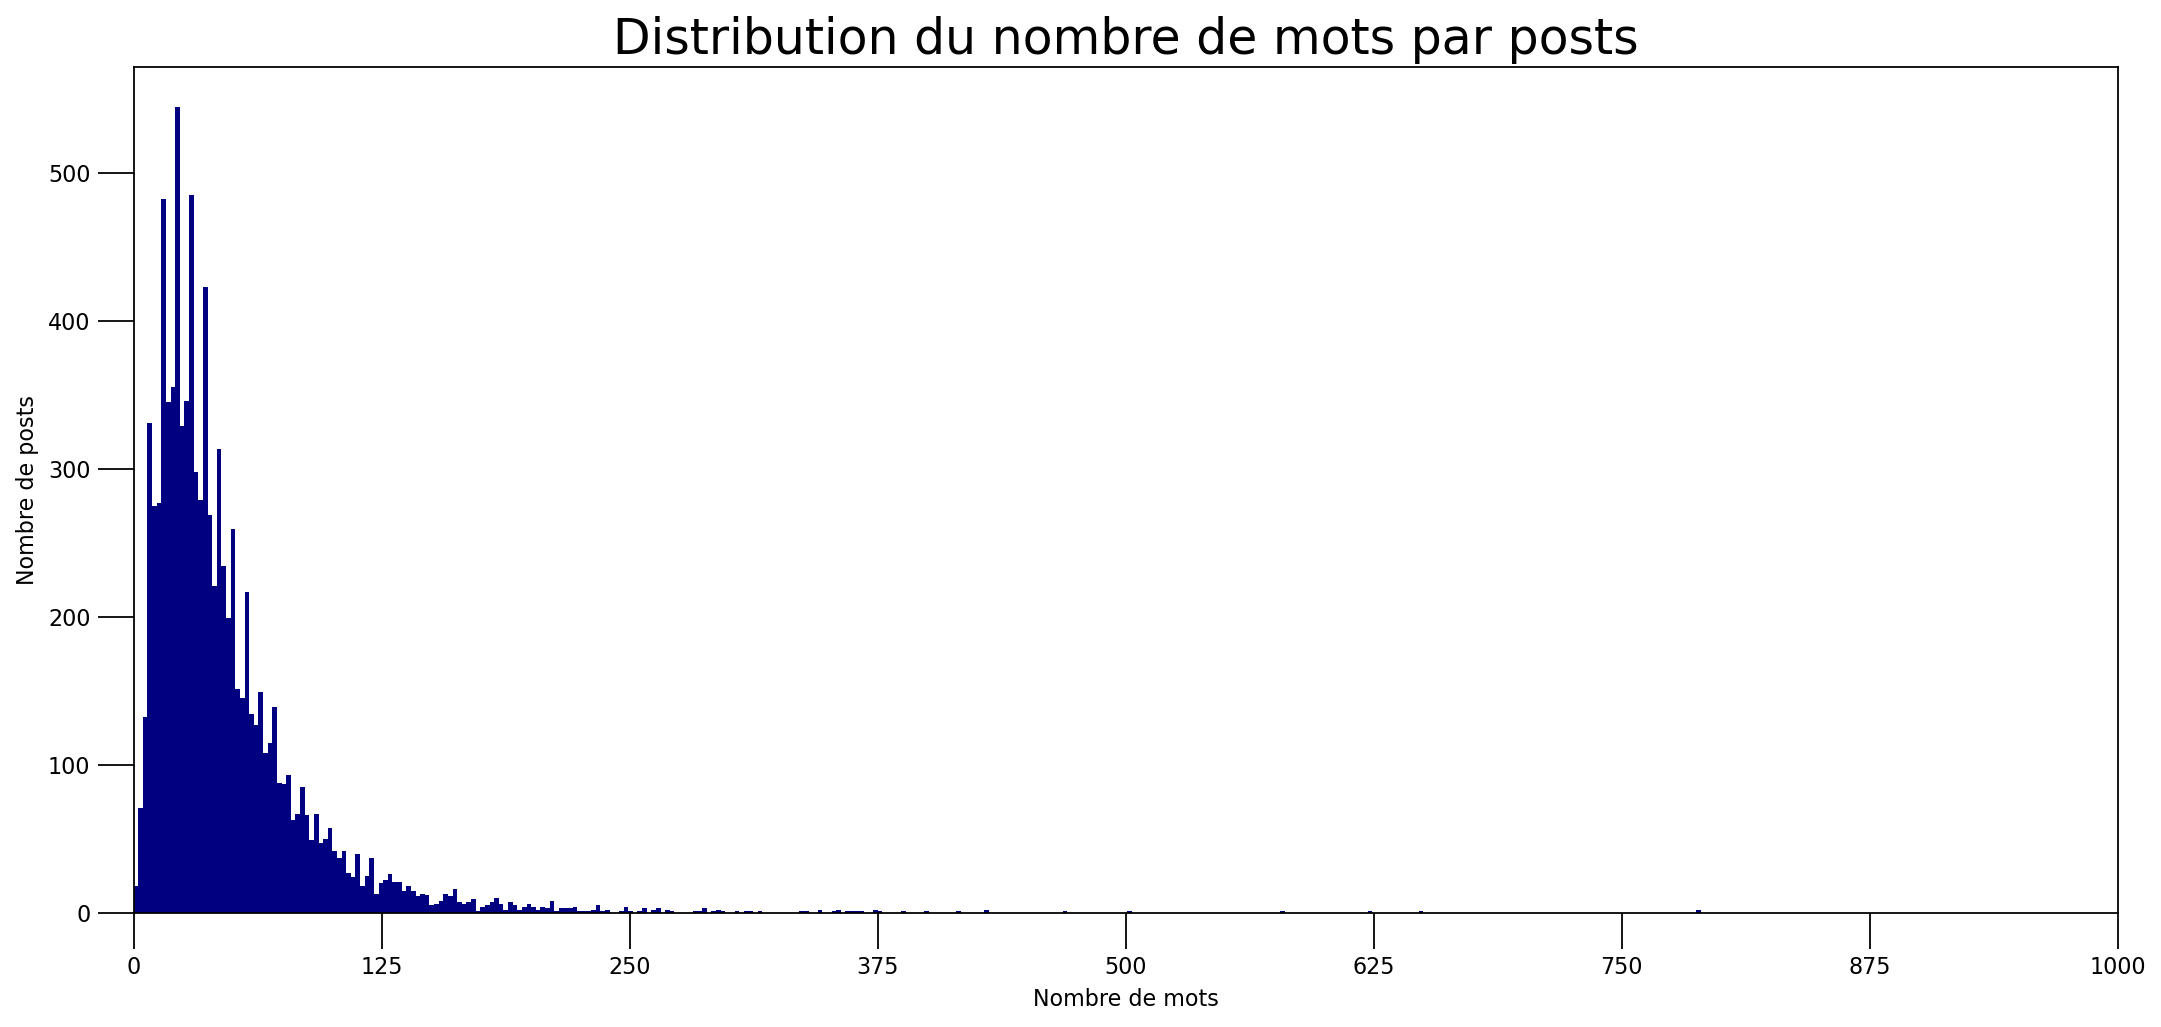

In [34]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
"""
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
"""
plt.gca().set(xlim=(0, 1000), ylabel='Nombre de posts', xlabel='Nombre de mots')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution du nombre de mots par posts', fontdict=dict(size=22))
plt.show()

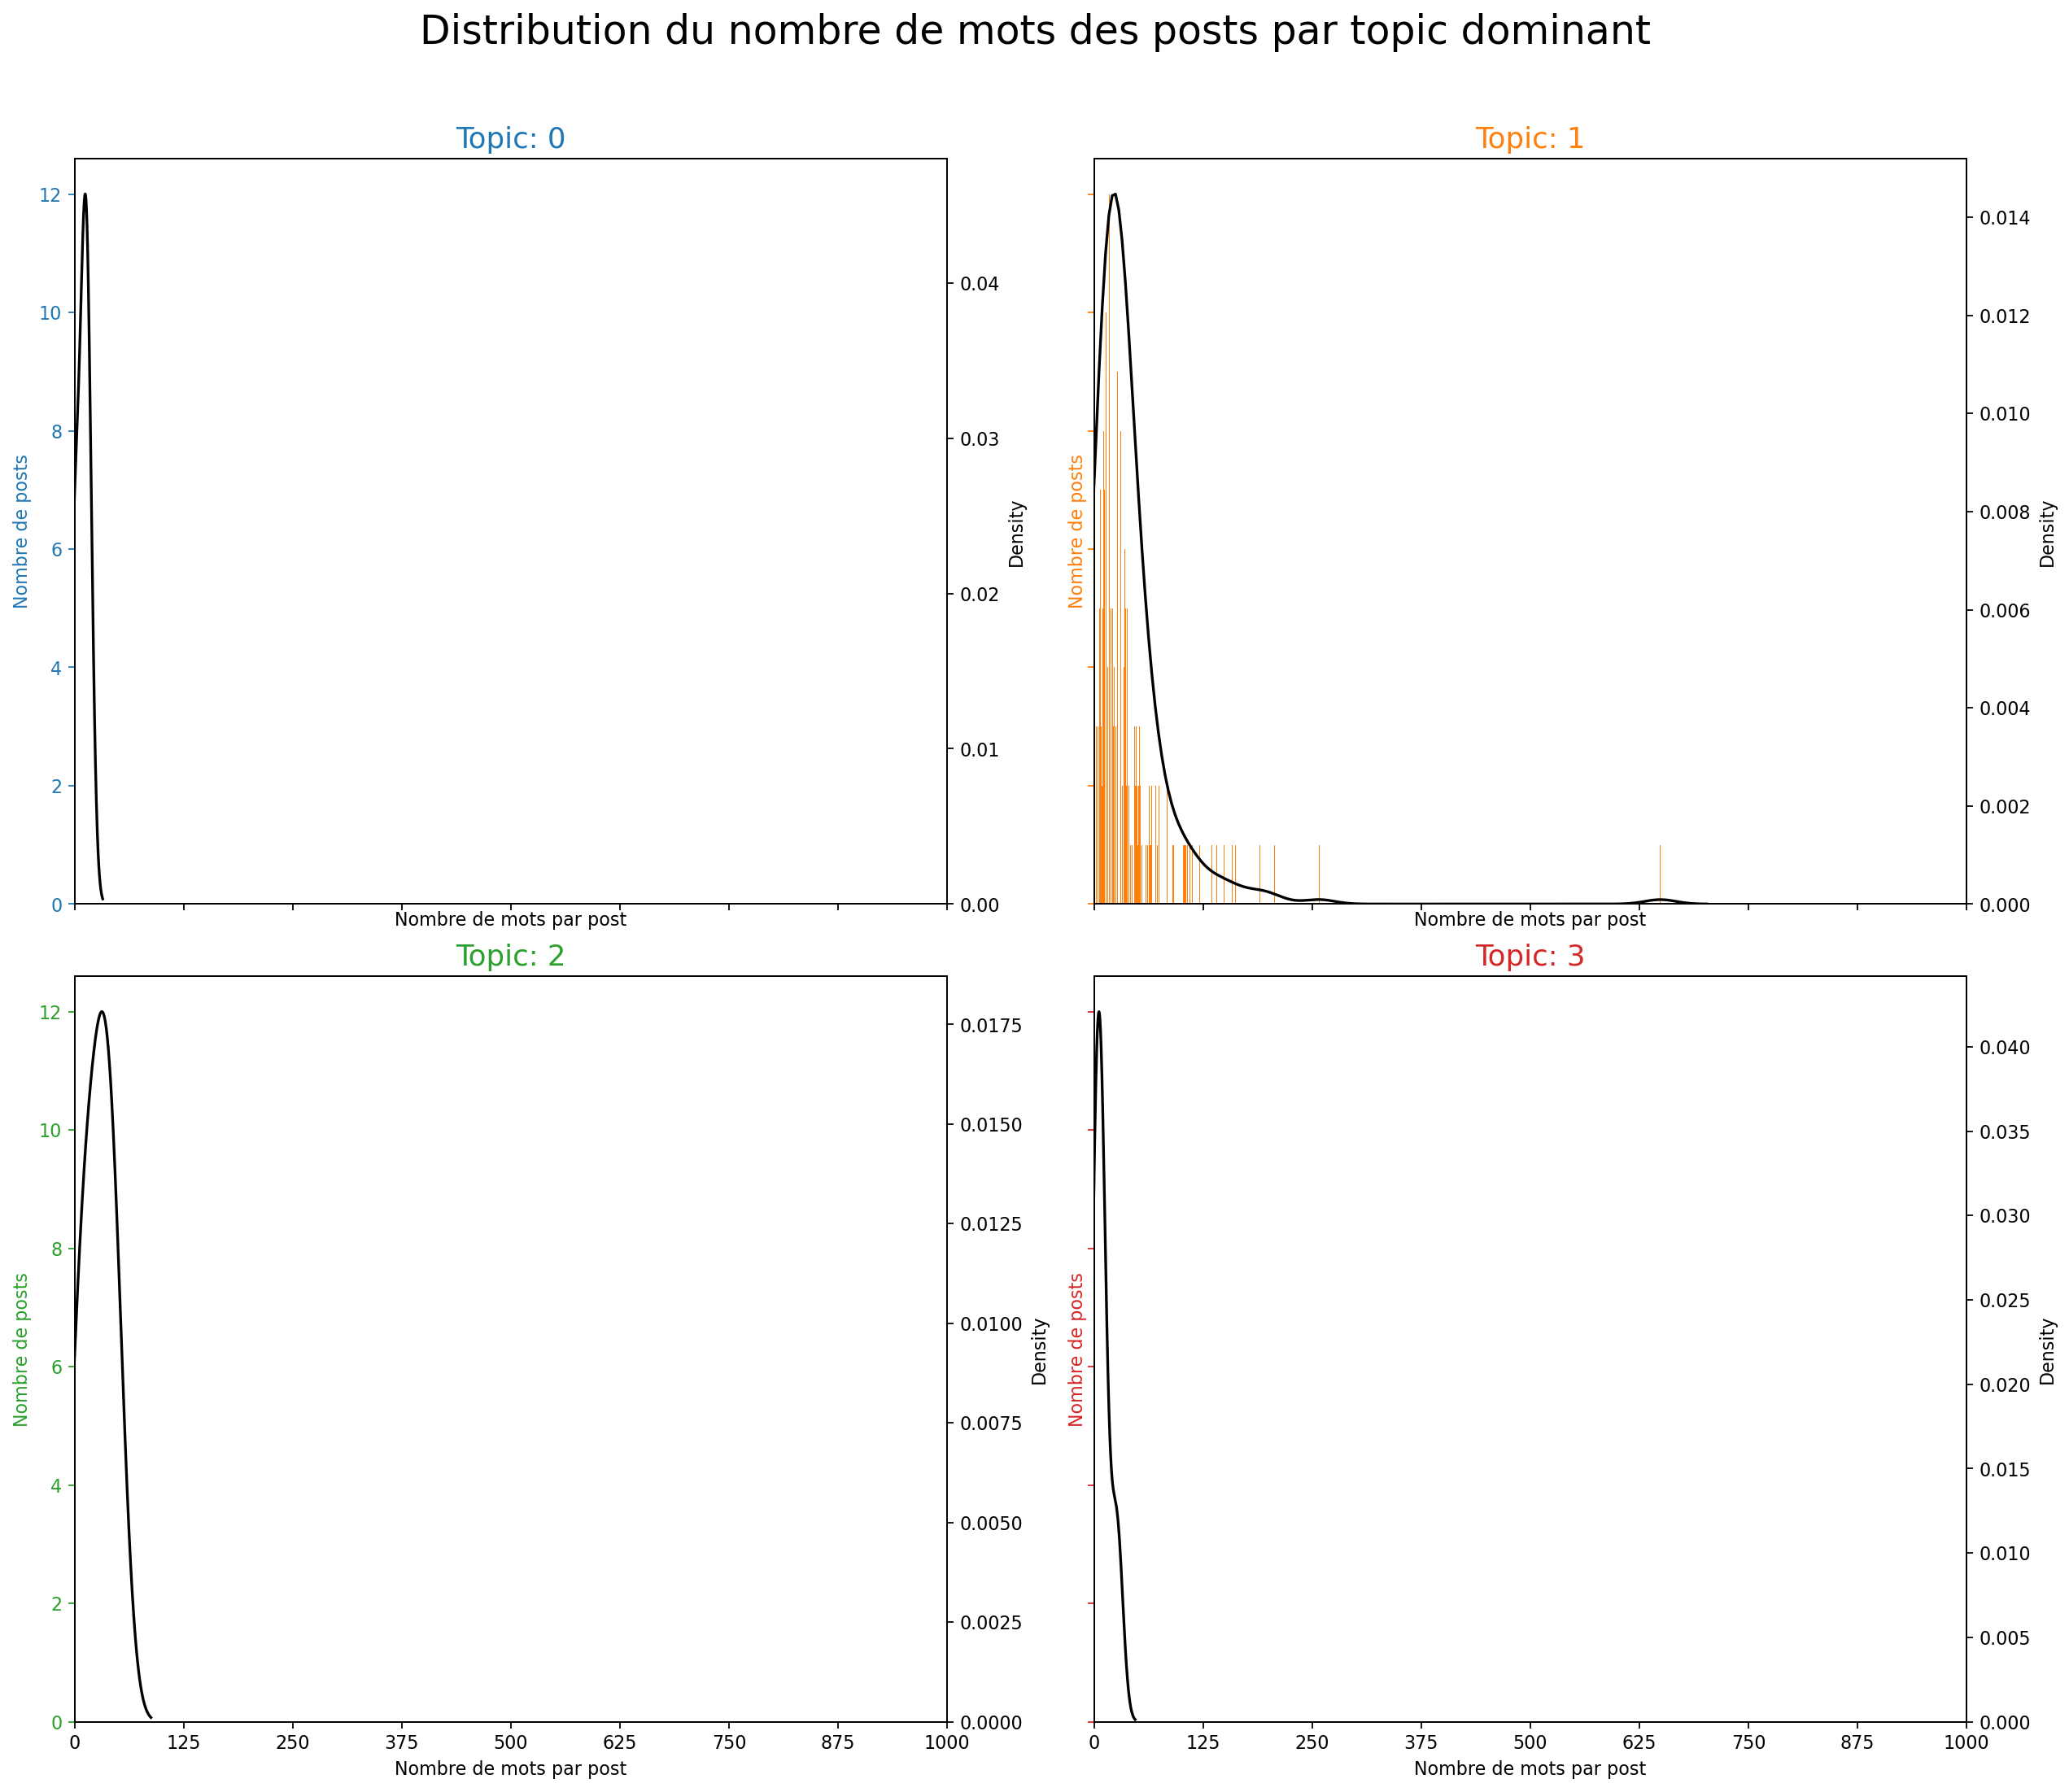

In [35]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Nombre de mots par post')
    ax.set_ylabel('Nombre de posts', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution du nombre de mots des posts par topic dominant', fontsize=22)
plt.show()

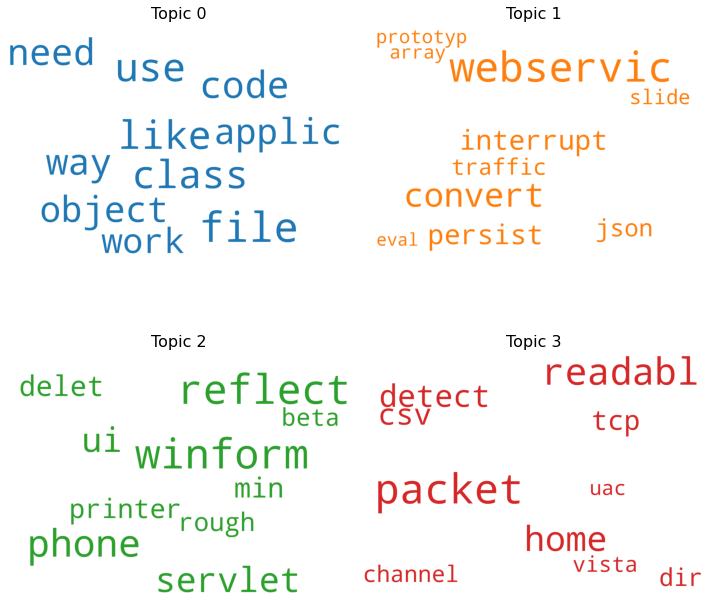

In [36]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf_optimized.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Nombre d'occurences d'un mot et poids dans les topics

On cherche à dégager les termes revenant souvent dans les topics dont la fréquence d'apparition est supérieure à leur poids dans le topic. 

Cela permet de montrer l'importance relative d'un terme dans le topic.

        word  topic_id  importance  word_count
0  webservic         3    0.073135         123
1    convert         3    0.045801         401
2    persist         3    0.029414         107
3  interrupt         3    0.029396          18
4       json         3    0.021980         109
5    traffic         3    0.019515          54
6      slide         3    0.015736          30
7   prototyp         3    0.013453          74
8      array         3    0.013201         641
9       eval         3    0.011454          30


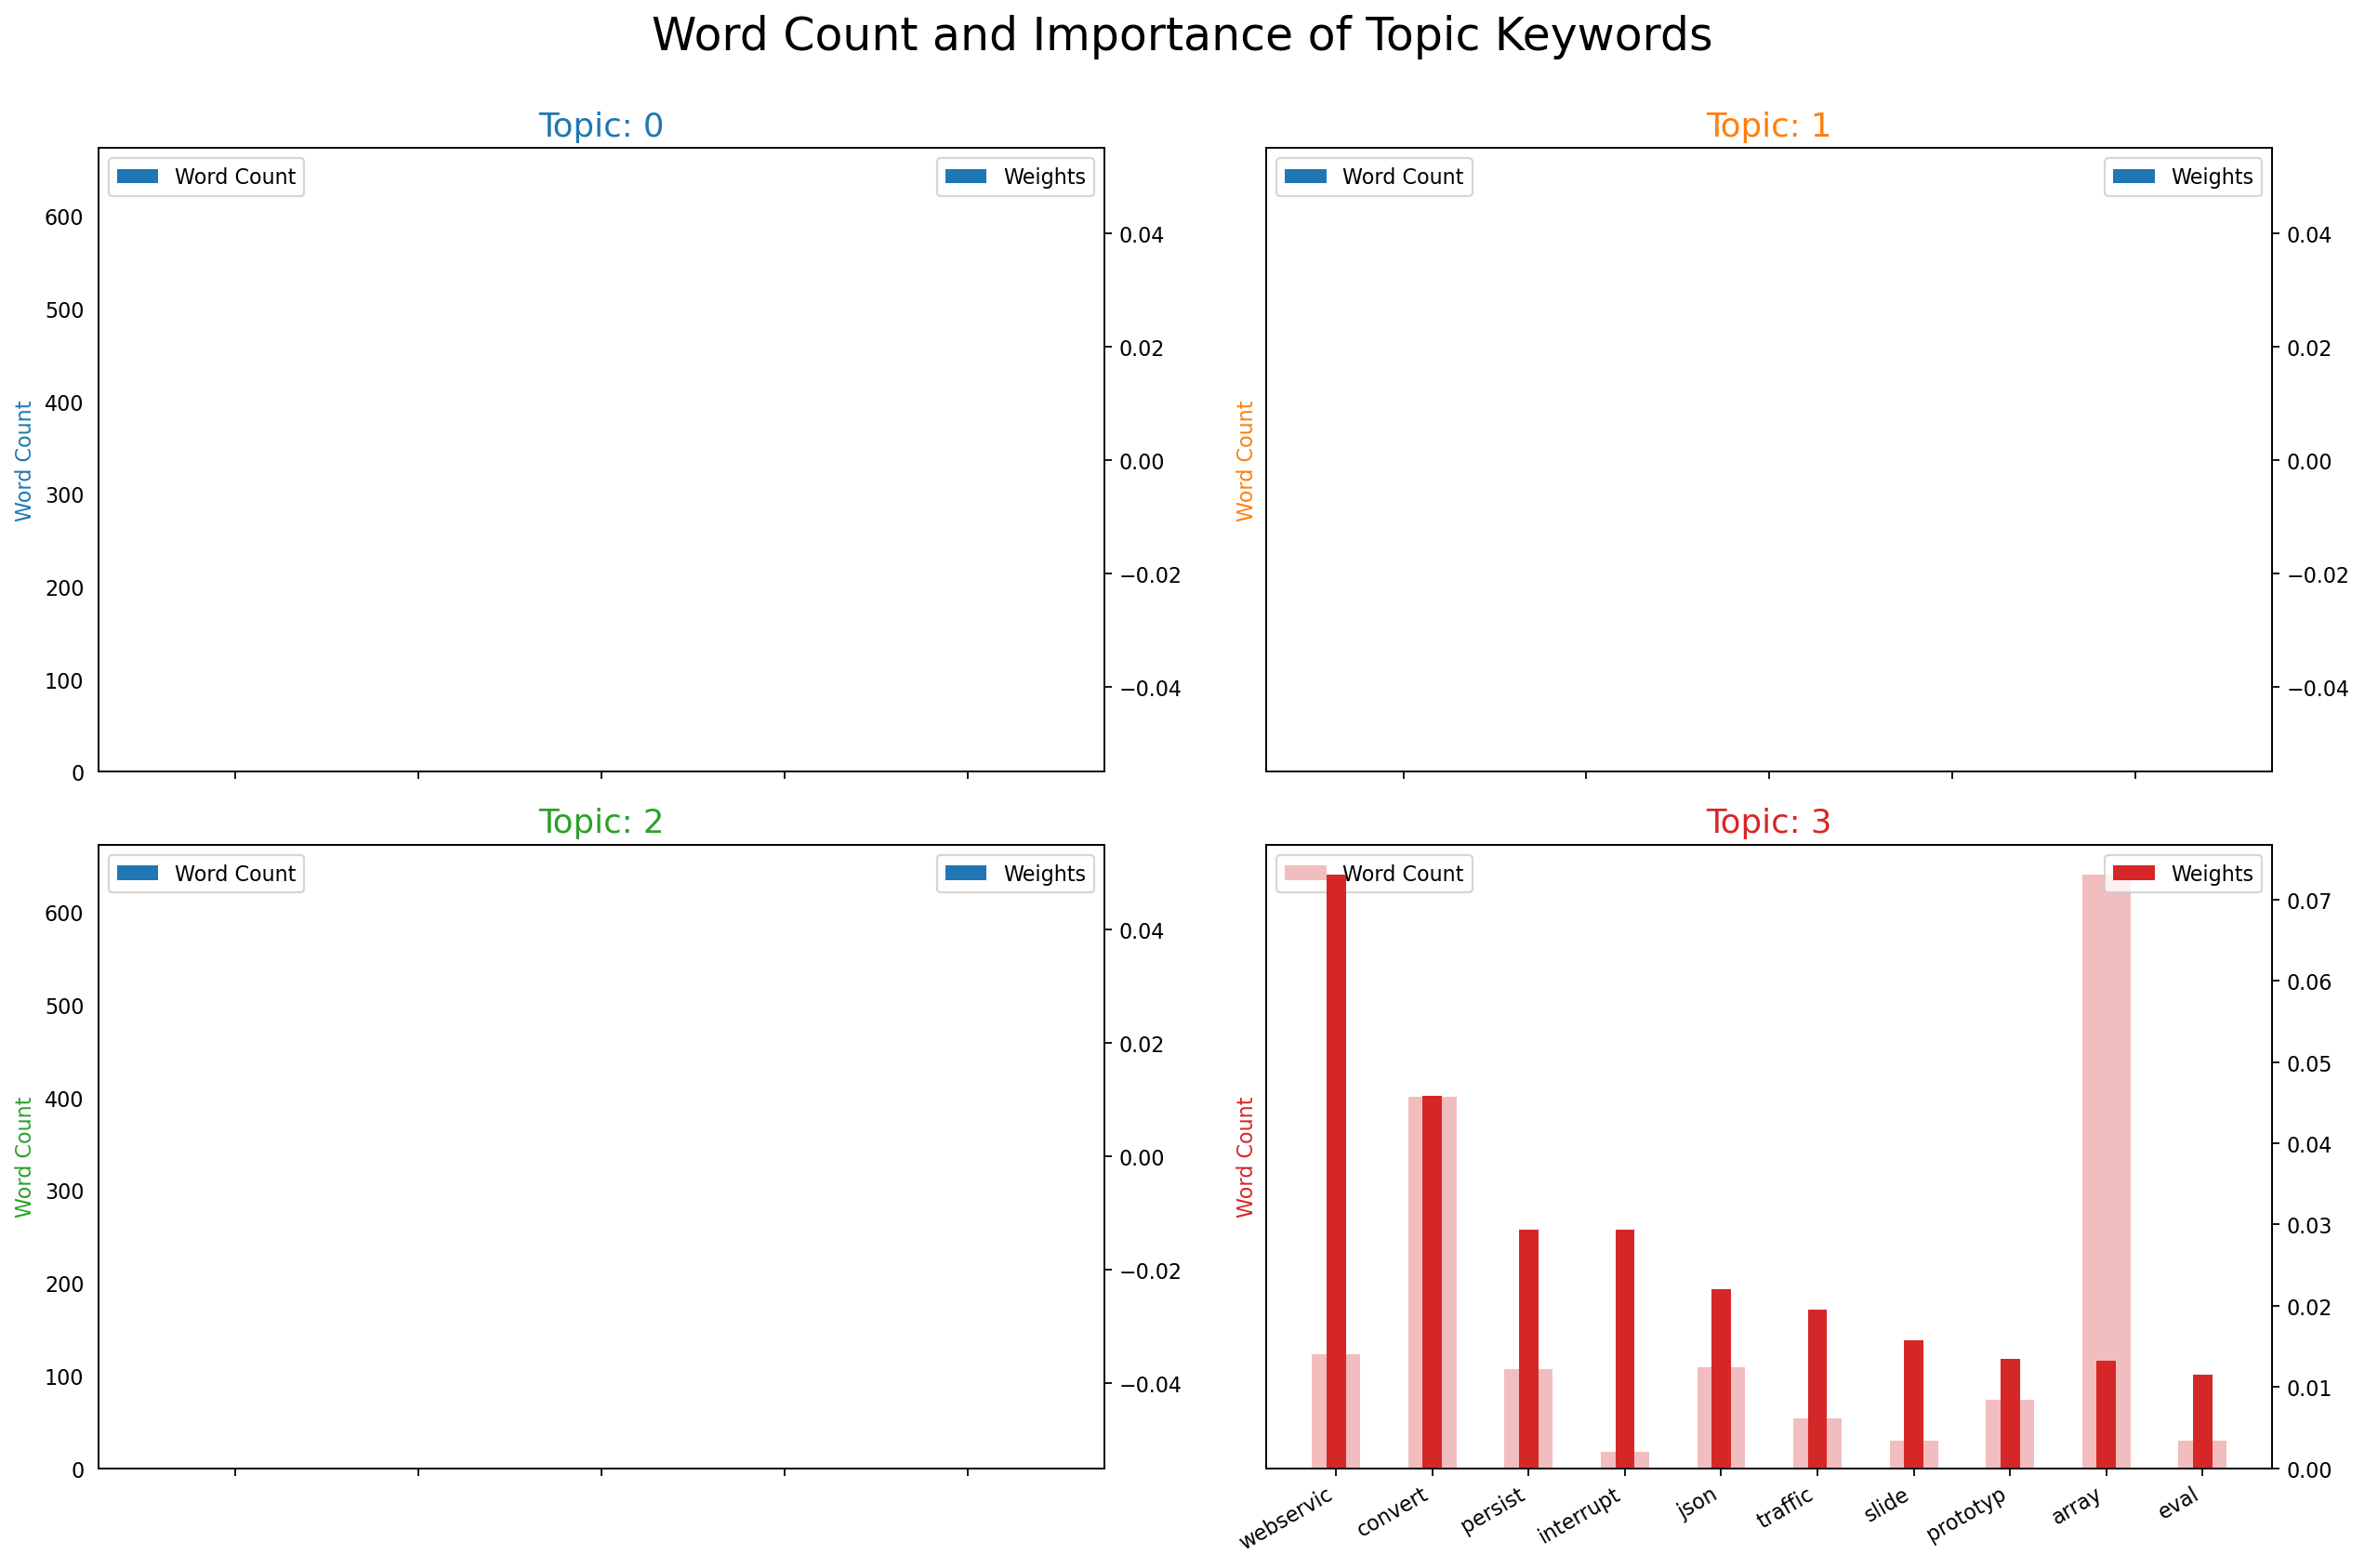

In [41]:

topics = lda_model_tfidf_optimized.show_topics(formatted=False)
data_flat = [w for w_list in processed_body for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

print(df.head(10))

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#### Représentativité des topics

In [42]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(lda_model_tfidf_optimized, corpus_tfidf, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model_tfidf_optimized.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

On fait deux graphes: 
    
    Nombre de posts pour chaque topic auquel on assigne le post dans lequel il a le plus de poids 
    Nombre de topics pour chaque post où leur poids contribue significativement 

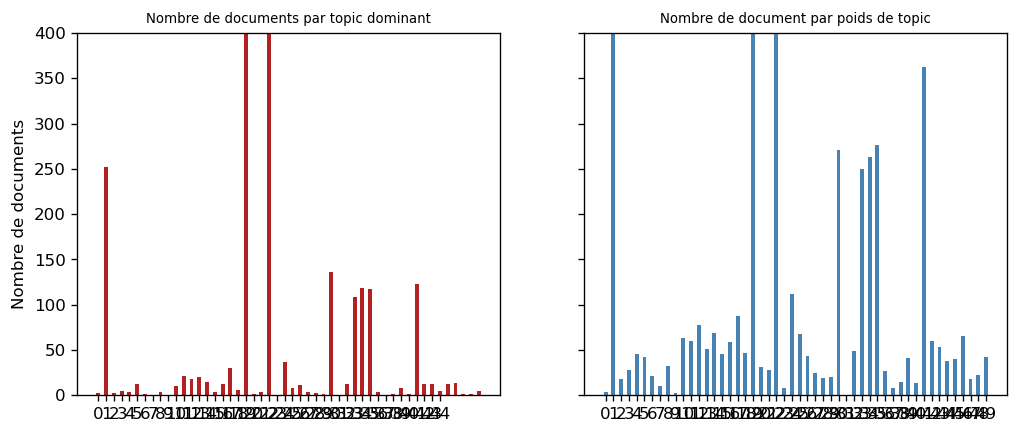

In [51]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
#tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
#ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Nombre de documents par topic dominant', fontdict=dict(size=8))
ax1.set_ylabel('Nombre de documents')
ax1.set_ylim(0, 400)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
#ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Nombre de document par poids de topic', fontdict=dict(size=8))

plt.show()

#### Représentation interactive des topics

In [44]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_tfidf_optimized, corpus_tfidf, dictionary=lda_model_tfidf_optimized.id2word,mds='tsne')
vis

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
19      26.647009  189.131851       1        1  41.891659
22      42.484718  170.574600       2        1   9.518988
1       72.459961  190.260406       3        1   5.058944
41      87.250000  133.839050       4        1   4.239873
35      23.751678  125.503311       5        1   3.226889
34      25.962219 -155.104446       6        1   3.077061
30    -158.302032   10.905421       7        1   3.029726
33      89.884468   93.014961       8        1   2.869527
24    -115.854134   20.128563       9        1   1.440149
17    -135.746292   77.454674      10        1   1.161960
12      -1.819096  -95.694908      11        1   1.069783
25    -119.388741  -78.191704      12        1   0.946097
14     123.232147   31.268803      13        1   0.943874
10    -112.568382  -29.851532      14        1   0.932476
46      97.669128  -55.819908      15        1   0.931188
11      91.989632 -108.445831      16        1   0.850018
16     124.019402  -18.792004      17        1   0.839122
42     -75.996315 -103.578835      18        1   0.829984
43     -34.997829  122.620987      19        1   0.794124
13     -30.709698 -127.414223      20        1   0.783691
32     -40.592350  -80.987961      21        1   0.745952
18     -80.944008  103.748848      22        1   0.719606
26      58.087650  -71.643997      23        1   0.715851
4       36.335865 -104.273399      24        1   0.714635
15     -74.619400  -52.370014      25        1   0.698670
45     -89.548195   57.753342      26        1   0.667772
39      -6.389626   83.708931      27        1   0.665602
49      79.103844   43.556953      28        1   0.663553
5      -46.913582   74.515869      29        1   0.662954
44      37.815445   77.365128      30        1   0.634294
8       52.668533  -35.805382      31        1   0.572526
20     -79.155914   -2.732092      32        1   0.567612
21      39.047840   41.850014      33        1   0.535400
3      -64.894592   33.429119      34        1   0.527028
36       5.243257   49.713844      35        1   0.524774
27      80.120842  -10.134245      36        1   0.512568
48      54.547329   12.645992      37        1   0.483392
6      -37.057091  -44.875908      38        1   0.472710
29     -51.682606  -19.492943      39        1   0.465031
47     -43.296558   12.826818      40        1   0.459441
28      -8.504197  -55.922806      41        1   0.449040
2      -28.460897   44.178257      42        1   0.442847
38      33.758331   -9.406446      43        1   0.414126
40      22.546158  -58.845924      44        1   0.391516
7       14.543262  -30.369286      45        1   0.350158
23     -10.877475   19.830143      46        1   0.338954
37      17.717546   17.544777      47        1   0.335296
0      -23.318098   -4.808240      48        1   0.289397
9        3.514629   -4.761122      49        1   0.284817
31     -12.306061  -26.150894      50        1   0.259346, topic_info=           Term        Freq       Total Category  logprob  loglift
430         net  109.000000  109.000000  Default  30.0000  30.0000
334       array   68.000000   68.000000  Default  29.0000  29.0000
94         file  196.000000  196.000000  Default  28.0000  28.0000
423         asp   57.000000   57.000000  Default  27.0000  27.0000
34         tabl  113.000000  113.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
23   particular    0.005809   22.915632  Topic50  -9.8012  -2.3254
25     platform    0.005809   15.468386  Topic50  -9.8012  -1.9324
27      problem    0.005809  103.332311  Topic50  -9.8012  -3.8315
28    programat    0.005809    4.888033  Topic50  -9.8012  -0.7804
29   programmat    0.005809   10.122645  Topic50  -9.8012  -1.5084

[2171 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1008     32  0.756737  abbrevi
262   

In [45]:
pyLDAvis.save_html(vis, 'lda2.html')

#### Save model

In [54]:
lda_model_tfidf_optimized.save('./models/lda_model_tfidf_optimized_2')

#### Prédiction

Pour effectuer les prédictions de tags on construit la matrice permettant d'associer les tags de chaque question d'entrainement au topic dominant de cette question.

Par récursivité on construit un indicateur de distribution du tag pour un topic donné.

In [193]:
#Détermination du nombre de tags unique du dataset
full_list = []
for tag in data['tags']: 
    for t in tag.split(','):
        full_list.append(t)
uniques = sorted(set(full_list))

In [194]:
#initialisation de la matrice réceptacle [tags x Topics]
unit_topics_matrix = []
for i in range(50):
    unit_topics_matrix.append(0)

In [195]:
# initialisation de la matrice cible
tags_topics_matrix = []
tags_topics_matrix = [[] for x in range(len(uniques))]
for i in range(len(uniques)):
    tags_topics_matrix.append(unit_topics_matrix)

In [196]:
#alimentation de la matrice
for index, row in df_dominant_topic.iterrows():    
    dominant_topic = row['Dominant_Topic']
    percentage = row['Topic_Perc_Contrib']
    document_id = row['Document_No']
    document_tags = data.loc[document_id]['tags']
    for tag in document_tags.split(','):
        tags_topics_matrix[int(uniques.index(tag))][int(dominant_topic)] = tags_topics_matrix[int(uniques.index(tag))][int(dominant_topic)] + percentage


In [207]:
tags_name = []
for t in uniques:
    tags_name.append(t)

In [208]:
lda_tags_df = pd.DataFrame(tags_topics_matrix, index=tags_name)

In [209]:
lda_tags_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
.emf,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0,0.0,0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.3603,0.0000,0.0,0.0000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0,0.0,0.0000,0.000,0.0000,0.0,0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000
.htaccess,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0,0.0,0,0.4135,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0000,4.4870,0.0000,0.0,0.3653,0,0.0,0.0,0.0,0.0,0.0,0.0,0.5787,0,0.0,1.4214,0.000,0.0000,0.0,0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000
.net,0.0,14.1055,0.0,0.0,0.4459,0.0,0.3418,0,0.0,0,0.5916,1.9751,0.0,0.7173,1.4172,0.0,0.7981,0.0,0.1655,295.3225,0.4111,0.0,23.2729,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0844,0,0.0,1.9379,2.634,1.0311,0.0,0,0.0,0.0,0.0,0.9815,0.4978,0.0,0.0,0.6972,0.0,0.0,0.0,0.9229
.net-2.0,0.0,0.3351,0.0,0.0,0.0000,0.0,0.0000,0,0.0,0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0000,7.5515,0.0000,0.0,1.1350,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0,0.0,0.0000,0.000,0.0000,0.0,0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.2715,0.0,0.0,0.0,0.0000
.net-3.5,0.0,0.9463,0.0,0.0,0.0000,0.0,0.0000,0,0.0,0,0.0000,0.2891,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0000,13.9154,0.0000,0.0,4.0095,0,0.0,0.0,0.0,0.0,0.0,0.0,0.4310,0,0.0,0.0000,0.000,0.4456,0.0,0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.3327


In [216]:
#normalisation
x = lda_tags_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
lda_tags_df_scaled = pd.DataFrame(min_max_scaler.fit_transform(x), columns=lda_tags_df.columns, index=lda_tags_df.index)

In [236]:
lda_tags_df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
.emf,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000644,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
.htaccess,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.243982,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.008024,0.0,0.0,0.005646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074035,0.0,0.0,0.227924,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
.net,0.0,0.692468,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.349068,0.829108,0.0,0.480571,0.557755,0.0,0.986039,0.0,0.254459,0.528114,1.0,0.0,0.359718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138730,0.0,0.0,0.310745,0.386773,0.101675,0.0,0.0,0.0,0.0,0.0,0.167806,0.521093,0.0,0.0,0.792363,0.0,0.0,0.0,0.761720
.net-2.0,0.0,0.016451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.013504,0.0,0.0,0.017543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.308558,0.0,0.0,0.0,0.000000
.net-3.5,0.0,0.046456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.121358,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.024884,0.0,0.0,0.061973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055139,0.0,0.0,0.000000,0.000000,0.043940,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.274596


In [233]:
pickle.dump(lda_tags_df_scaled, open('./models/lda_tags_df_scaled.obj', 'wb'))

In [235]:
pickle.dump(dictionary, open('./models/dictionary.obj', 'wb'))

In [234]:
lda = gensim.models.LdaMulticore.load('./models/lda_model_tfidf_optimized_2')

In [227]:
def lda_predict(txt, lda_tags_df_scaled):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    stemmer = EnglishStemmer()
    stemmed = ' '.join(stemmer.stem(WordNetLemmatizer().lemmatize(w, pos='v')) for w in w_tokenizer.tokenize(txt))

    pattern = re.compile('[^A-Za-z +]')
    normalized = re.sub(pattern, ' ', stemmed)

    result = []
    for token in gensim.utils.simple_preprocess(normalized):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(token)
    this_dictionary = []
    this_dictionary.append(result)
    
    other_corpus = [dictionary.doc2bow(text) for text in this_dictionary]
    unseen_doc = other_corpus[0]
    vector = lda[unseen_doc]

    topic = vector[0][0][0]
    perc = vector[0][0][1]
    tags = lda_tags_df_scaled[int(topic)]
    tags_output = tags.sort_values(ascending=False).head(5)    
    
    return tags_output


In [228]:
#"""
new_text = "Hello, I am developing a new application in django with html and javascript \
and I need to create a new table in a sql-server database. Can you tell me how to do it ? Thanks !"
#"""
#new_text = "I run a python script and I have a memory problem, it says it is a language problem. Can you help me ?"
#new_text = "how can I run a java class file that contains a function ?"
#new_text = "How can I print all files from the folder that are in my project in a single command ?"

tags_output = lda_predict(new_text, lda_tags_df_scaled)
tags_output

design-patterns    1.000000
django             0.705087
python             0.495370
django-urls        0.300746
django-views       0.300746
Name: 5, dtype: float64

In [232]:
for index in tags_output.index:
    print(index)

design-patterns
django
python
django-urls
django-views
